This notebook is aimed at analyzing the career statistics of two of the UFC's most accomplished grapplers: Demian Maia and Khabib Nurmagomedov.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
from sqlalchemy import create_engine
from src import local
from src import functions
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

### Grappling Stats import
Here we import our grappling stats data, this has advanced statistics on reversals, submission attempts, and guard passes for every round in the UFC

In [2]:
grappling = pd.read_csv('../../data/ufcstats_data/grappling_stats.csv')
grappling.head()

,round,bout_link,fighter_link,rev_p1m,rev_p15m,pass_p1m,pass_p15m,sub_att_p1m,sub_att_p15m,rev_pr_di,rev_p1m_di,rev_p15m_di,pass_pr_di,pass_p1m_di,pass_p15m_di,sub_att_pr_di,sub_att_p1m_di,sub_att_p15m_di
0,1,http://www.ufcstats.com/fight-details/11f715fa...,http://www.ufcstats.com/fighter-details/e1147d...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
1,2,http://www.ufcstats.com/fight-details/11f715fa...,http://www.ufcstats.com/fighter-details/e1147d...,0.0,0.0,0.2,3.0,0.0,0.0,0,0.0,0.0,1,0.2,3.0,0,0.0,0.0
2,3,http://www.ufcstats.com/fight-details/11f715fa...,http://www.ufcstats.com/fighter-details/e1147d...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
3,4,http://www.ufcstats.com/fight-details/11f715fa...,http://www.ufcstats.com/fighter-details/e1147d...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
4,5,http://www.ufcstats.com/fight-details/11f715fa...,http://www.ufcstats.com/fighter-details/e1147d...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0


We also want the takedown statistics as well as the strikes thrown on the ground.

In [3]:
ground_strikes = pd.read_csv('../../data/ufcstats_data/ground_ss_stats.csv')
takedowns = pd.read_csv('../../data/ufcstats_data/takedown_stats.csv')

In order to get name and date information, we need to merge these dataframes with our bouts and fighters tables. For this, we'll use sql as it will allow us to specify the exact rows we want.

In [4]:
# Credentials
USER = local.user 
PASS = local.password
HOST = local.host
PORT = local.port

#create engine
engine = create_engine(f'postgresql://{USER}:{PASS}@{HOST}:{PORT}/match_finder')

In [5]:
query = """
SELECT name, link
FROM fighters
"""

fighters = pd.read_sql(query, engine)

In [6]:
fighters.head()

,name,link
0,Fabiano Scherner,http://www.ufcstats.com/fighter-details/0bc7e6...
1,Alexandre Dantas,http://www.ufcstats.com/fighter-details/8dc46e...
2,Kevin Burns,http://www.ufcstats.com/fighter-details/a6d8bf...
3,Joseph Sandoval,http://www.ufcstats.com/fighter-details/696002...
4,Jose Aldo,http://www.ufcstats.com/fighter-details/d0f395...


In [7]:
query = """
SELECT "Date" as date, bouts.link
FROM bouts
JOIN events on events.link = bouts.event_link
"""

bouts = pd.read_sql(query, engine)

In [8]:
bouts.head()

,date,link
0,"July 25, 2020",http://www.ufcstats.com/fight-details/11f715fa...
1,"July 25, 2020",http://www.ufcstats.com/fight-details/11f715fa...
2,"July 25, 2020",http://www.ufcstats.com/fight-details/11f715fa...
3,"July 25, 2020",http://www.ufcstats.com/fight-details/11f715fa...
4,"July 25, 2020",http://www.ufcstats.com/fight-details/11f715fa...


In [9]:
grappling = grappling.join(fighters.set_index('link'), on='fighter_link')
ground_strikes = ground_strikes.join(fighters.set_index('link'), on='fighter_link')
takedowns = takedowns.join(fighters.set_index('link'), on='fighter_link')

In [10]:
grappling = grappling.join(bouts.set_index('link'), on='bout_link')
ground_strikes = ground_strikes.join(bouts.set_index('link'), on='bout_link')
takedowns = takedowns.join(bouts.set_index('link'), on='bout_link')

we can easily get the career averages by grouping a column by the fighters name and getting the average for whatever stat we want. First we'll look at the the Takedown Successes Differential per 15 Minutes, which is denoted as td_s_p15m_di in our table. This is a measure of how many more takedowns a fighter landed than their opponent for each 15 minutes they've fought in the UFC.

In [11]:
takedowns.groupby('name').td_s_p15m_di.mean().sort_values(ascending=False)[:30]

name
Brad Kohler              30.000000
James Lee                20.000000
TJ Brown                 12.192661
Mike Nickels             10.463472
Homer Moore               9.681818
Mark Madsen               9.125000
Travis Wiuff              9.100000
Manuel Rodriguez          9.090909
Roman Mitichyan           8.960145
Herbert Burns             8.385736
Merab Dvalishvili         8.333333
Juan Espino               8.333333
Tom Murphy                7.521008
Christina Marks           7.500000
Gadzhimurad Antigulov     7.429470
Robert Drysdale           7.317073
Royce Alger               7.196203
Jason Godsey              7.031250
Jake Rosholt              6.963419
Allen Berube              6.870229
Tatiana Suarez            6.788785
Khamzat Chimaev           6.753968
Michel Batista            6.716418
Rodolfo Vieira            6.626426
Keith Rockel              6.489461
Mike Wessel               6.488372
Ronda Rousey              6.487653
Sanae Kikuta              6.474820
Curtis Blaydes 

It looks like we have a lot of fighters who haven't fought in the ufc very much which likely skewed their numbers pretty high. We'll filter it by fighters who have at least 3 fights in the UFC.

In [12]:
bouts_by_name = pd.DataFrame(takedowns.groupby(['bout_link', 'fighter_link']).name.max())

In [13]:
number_of_bouts = bouts_by_name.groupby('name').name.count()
number_of_bouts

name
Aalon Cruz            1
Aaron Brink           1
Aaron Phillips        3
Aaron Riley           9
Aaron Rosa            3
                     ..
Zarah Fairn           2
Zarrukh Adashev       1
Zelim Imadaev         2
Zhalgas Zhumagulov    1
Zubaira Tukhugov      6
Name: name, Length: 1918, dtype: int64

Now that we have match counts for every fighter we will create a list of fighters with less than 3 bouts.

In [14]:
inexperienced_fighters = list(number_of_bouts[number_of_bouts<3].index)
len(inexperienced_fighters)

675

In [15]:
mask = takedowns.name.map(lambda x: functions.black_list_entry(x, inexperienced_fighters))
takedowns = takedowns[mask]

In [16]:
takedowns

,Unnamed: 0,round,bout_link,fighter_link,td_a_p1m,td_s_p1m,td_a_p15m,td_s_p15m,td_ac,td_de,td_s_pr_di,td_a_pr_di,td_s_p1m_di,td_a_p1m_di,td_s_p15m_di,td_a_p15m_di,name,date
0,0,1,http://www.ufcstats.com/fight-details/11f715fa...,http://www.ufcstats.com/fighter-details/e1147d...,0.400000,0.0,6.000000,0.0,0.0,NaN,0,2,0.0,0.400000,0.0,6.000000,Robert Whittaker,"July 25, 2020"
0,0,1,http://www.ufcstats.com/fight-details/11f715fa...,http://www.ufcstats.com/fighter-details/e1147d...,0.400000,0.0,6.000000,0.0,0.0,NaN,0,2,0.0,0.400000,0.0,6.000000,Robert Whittaker,"July 25, 2020"
0,0,1,http://www.ufcstats.com/fight-details/11f715fa...,http://www.ufcstats.com/fighter-details/e1147d...,0.400000,0.0,6.000000,0.0,0.0,NaN,0,2,0.0,0.400000,0.0,6.000000,Robert Whittaker,"July 25, 2020"
0,0,1,http://www.ufcstats.com/fight-details/11f715fa...,http://www.ufcstats.com/fighter-details/e1147d...,0.400000,0.0,6.000000,0.0,0.0,NaN,0,2,0.0,0.400000,0.0,6.000000,Robert Whittaker,"July 25, 2020"
0,0,1,http://www.ufcstats.com/fight-details/11f715fa...,http://www.ufcstats.com/fighter-details/e1147d...,0.400000,0.0,6.000000,0.0,0.0,NaN,0,2,0.0,0.400000,0.0,6.000000,Robert Whittaker,"July 25, 2020"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25754,12868,3,http://www.ufcstats.com/fight-details/d9e86958...,http://www.ufcstats.com/fighter-details/621a6c...,0.200000,0.0,3.000000,0.0,0.0,NaN,0,1,0.0,0.200000,0.0,3.000000,Matt Hughes,"September 24, 1999"
25760,12874,1,http://www.ufcstats.com/fight-details/62ac5bff...,http://www.ufcstats.com/fighter-details/33e33d...,0.000000,0.0,0.000000,0.0,NaN,0.0,-1,-1,-0.2,-0.200000,-3.0,-3.000000,Maurice Smith,"July 16, 1999"
25763,12877,1,http://www.ufcstats.com/fight-details/38e3986b...,http://www.ufcstats.com/fighter-details/4f74c8...,0.213523,0.0,3.202847,0.0,0.0,NaN,0,1,0.0,0.213523,0.0,3.202847,Daiju Takase,"July 16, 1999"
25765,12879,1,http://www.ufcstats.com/fight-details/3e4199f9...,http://www.ufcstats.com/fighter-details/b76ed5...,0.200000,0.0,3.000000,0.0,0.0,NaN,0,1,0.0,0.200000,0.0,3.000000,Tsuyoshi Kohsaka,"July 16, 1999"


In [17]:
takedowns.groupby('name').td_s_p15m_di.mean().sort_values(ascending=False)[:20]

name
Merab Dvalishvili        8.333333
Gadzhimurad Antigulov    7.429470
Jake Rosholt             6.963419
Tatiana Suarez           6.788785
Ronda Rousey             6.487653
Curtis Blaydes           6.439129
Gregor Gillespie         6.251899
Jake O'Brien             5.683165
Murilo Bustamante        5.603226
Edmen Shahbazyan         5.583333
Jeremy Kennedy           5.179063
Bartosz Fabinski         5.148387
Khabib Nurmagomedov      5.143912
Zabit Magomedsharipov    5.098636
Corey Anderson           5.093446
Robert Sanchez           5.071803
Aaron Simpson            4.890756
Colby Covington          4.874457
Jordan Johnson           4.675325
Ramsey Nijem             4.616337
Name: td_s_p15m_di, dtype: float64

Now we see some more familiar names. We have Khabib at #13, but we also see Ronda Rousey at #5 and Curtis Blaydes at #6. These are all highly regarded grapplers and they are all in the top 15 for 15m takedown differential. But how do they compare to the rest of the UFC? Let's see how big our list is.

In [18]:
(13/len(takedowns.name.unique()))*100

1.045016077170418

These fighters are in the top 1% for 15m takedown differential.

#### Average Takedowns
But is a differential the best way to measure takedown ability? We could also look at the average number of successful takedowns per 15 minutes.

In [59]:
takedowns.groupby('name').td_s_p15m.mean().sort_values(ascending=False)[:20]

name
Merab Dvalishvili        8.666667
Jake Rosholt             8.316557
Gadzhimurad Antigulov    7.429470
Ronda Rousey             7.033108
Curtis Blaydes           6.839129
Tatiana Suarez           6.788785
Bartosz Fabinski         6.600000
Jake O'Brien             6.550602
Robert Sanchez           6.271803
Gregor Gillespie         6.251899
Jimmy Crute              6.241627
Edmen Shahbazyan         6.083333
Rodney Wallace           6.000000
Jeremy Kennedy           5.727273
Murilo Bustamante        5.603226
Zabit Magomedsharipov    5.500830
Aaron Simpson            5.426471
Wilson Reis              5.379805
Jimy Hettes              5.330846
Khabib Nurmagomedov      5.310579
Name: td_s_p15m, dtype: float64

You see a lot of the same names but Khabib dropped 7 places down to 20th place. In order for Khabib to be higher on the average takedown top 20, he would have to successfully land more takedowns, regardless of whether or not his opponent landed takedowns on him. If his opponents had landed more takedowns on him, he would be lower on the differential list, but he would stay at the same place on the average takedowns list. It would be ideal to have a differential that is identical to your average, because this would mean that you never gave up a takedown. What would a column look like if the takedown average was subtracted from the differential?

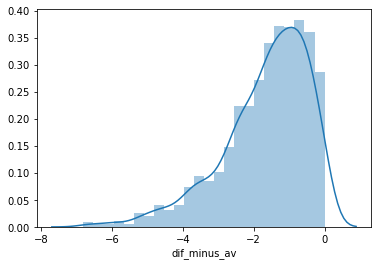

In [66]:
takedowns['dif_minus_av'] = takedowns.td_s_p15m_di - takedowns.td_s_p15m
sns.distplot(takedowns.groupby('name').dif_minus_av.mean())

In [65]:
takedowns.groupby('name').dif_minus_av.mean().sort_values()[:15]

name
Ben Alloway         -6.808143
Jason Gonzalez      -6.670549
Casey Kenney        -6.600000
Sean Soriano        -6.397527
Felipe Colares      -6.333333
Francisco Trevino   -6.112782
Rogerio Bontorin    -6.000000
Rafael Cavalcante   -5.909091
Jared Hamman        -5.900926
Drew McFedries      -5.894528
Garett Whiteley     -5.692308
Aaron Phillips      -5.630034
Ryan Jensen         -5.444704
Adam Milstead       -5.281780
James Irvin         -5.276480
Name: dif_minus_av, dtype: float64

This list doesn't have any familiar names, which is unsuprising, but if we look at the #2 spot, Jason Gonzalez, we'll notice that he fought Gregor Gilespie, our #7 ranked in takedown differential. 

This metric measures the number of takedowns that a fighter has given up and could be a good measurement of takedown defense.

### Submission attempts

In [75]:
mask = grappling.name.map(lambda x: functions.black_list_entry(x, inexperienced_fighters))
grappling = grappling[mask]

grappling.groupby('name').sub_att_p15m_di.mean().sort_values(ascending=False)[:15]

name
Ian Entwistle        19.497616
Ronda Rousey          7.800269
Sean McCorkle         7.407751
Paul Sass             7.218045
Rob Broughton         6.825243
Teemu Packalen        6.750000
Rousimar Palhares     6.291708
Genki Sudo            5.374214
TJ Waldburger         5.315116
Renato Sobral         4.920935
Patrick Williams      4.891304
Manny Bermudez        4.841381
Matt Arroyo           4.659574
Fabiano Iha           4.604762
Marcus Aurelio        4.446429
Name: sub_att_p15m_di, dtype: float64

In [78]:
grappling.groupby('name').pass_p15m_di.mean().sort_values(ascending=False)[:15]

name
Gregor Gillespie       13.220946
Tatiana Suarez         10.066494
Teemu Packalen          9.250000
Grant Dawson            8.779592
Murilo Bustamante       8.506452
Gillian Robertson       8.092862
Denis Kang              7.751553
Jake Rosholt            7.506276
Ronda Rousey            6.498034
Aspen Ladd              6.140637
Edmen Shahbazyan        5.666667
Claudio Silva           5.578009
Khabib Nurmagomedov     5.429699
Jimy Hettes             5.357632
Misha Cirkunov          5.107617
Name: pass_p15m_di, dtype: float64

In [80]:
grappling['combined_grappling_p15m_di'] = grappling['pass_p15m_di'] + grappling['sub_att_p15m_di'] + grappling['rev_p15m_di']
grappling.groupby('name').combined_grappling_p15m_di.mean().sort_values(ascending=False)[:20]

name
Ronda Rousey         19.869731
Ian Entwistle        18.268107
Teemu Packalen       15.000000
Gregor Gillespie     14.348343
Murilo Bustamante    11.777419
Genki Sudo           10.224538
Manny Bermudez       10.101642
Grant Dawson         10.010204
Gillian Robertson     9.435001
Tatiana Suarez        9.286136
Rousimar Palhares     8.947319
Misha Cirkunov        8.585120
TJ Waldburger         7.997151
Edmen Shahbazyan      7.750000
Diego Ferreira        7.694718
Joe Duffy             7.310531
Denis Kang            7.285714
Joe Lauzon            7.177872
Livinha Souza         6.904762
Claudio Silva         6.904596
Name: combined_grappling_p15m_di, dtype: float64

In [84]:
av_sub_att = grappling.groupby('name').sub_att_p15m_di.mean()

av_sub_att[av_sub_att.index == 'Demian Maia']

name
Demian Maia    1.045441
Name: sub_att_p15m_di, dtype: float64

In [86]:
av_rev = grappling.groupby('name').rev_p15m_di.mean()

av_rev[av_rev.index == 'Demian Maia']

name
Demian Maia   -0.023621
Name: rev_p15m_di, dtype: float64

In [87]:
av_pass = grappling.groupby('name').pass_p15m_di.mean()

av_pass[av_pass.index == 'Demian Maia']

name
Demian Maia    3.722007
Name: pass_p15m_di, dtype: float64

In [22]:
av_rev = takedowns.groupby('name').td_s_p15m_di.mean()

av_rev[av_rev.index == 'Conor McGregor']

name
Conor McGregor   -0.530995
Name: td_s_p15m_di, dtype: float64